In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [17]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [18]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [19]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


In [20]:
#preparing the data for the LSTM
def prepare_data(df):
  # df_aux = df.drop(columns=['nr_ruas_afetadas', 'comprimento_fila_metros', 'demora_fila_segundos'], inplace=False)
  df_aux = df
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.sort_values('data')
  df_aux = df_aux.set_index('data')
  return df_aux


In [21]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    df[['nr_ruas_afetadas']] = scaler.fit_transform(df[['nr_ruas_afetadas']])
    df[['comprimento_fila_metros']] = scaler.fit_transform(df[['comprimento_fila_metros']])
    df[['demora_fila_segundos']] = scaler.fit_transform(df[['demora_fila_segundos']])
    df[['Nr_acidentes']] = scaler.fit_transform(df[['Nr_acidentes']])

    return scaler

In [22]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [23]:
#Plot time series data
def plot_confirmed_cases(data):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)), data)
        plt.title('Dataset Features')
        plt.ylabel('Valores')
        plt.xlabel('Semanas')
        plt.show()

In [24]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [25]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [26]:
def build_model(timesteps, features, filters= 16, kernel_size=5, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(4)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

In [27]:
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

In [28]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    # prepare new input to forecast the next day
    list_pred = [pred[0][i] for i in range(len(pred[0]))]
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
            
  return forecasts

In [29]:
def plot_forecast(data, forecasts):
        plt.figure(figsize=(14,6))
        plt.plot(range(len(data)),data["Nr_acidentes"], color='green', label='Confirmed')
        
        fi=[]
        for f in forecasts:
          fi.append(f[0][0])
          print('Previsão:' + str(f))
        print(fi)
        
        plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
        plt.title('Nr de Acidentes em Braga')
        plt.ylabel('Value')
        plt.xlabel('Days')
        plt.legend()
        plt.show()

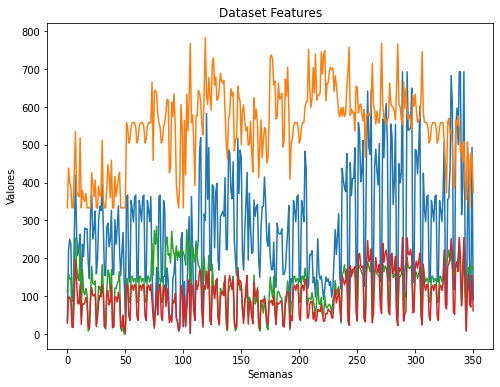

Epoch 1/10
16/16 [==============================] - 1s 13ms/step - loss: 0.4012 - mae: 0.3434 - rmse: 0.4013 - val_loss: 0.7077 - val_mae: 0.6820 - val_rmse: 0.6918
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.2836 - mae: 0.2363 - rmse: 0.2837 - val_loss: 0.6399 - val_mae: 0.6109 - val_rmse: 0.6242
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 0.2510 - mae: 0.2071 - rmse: 0.2511 - val_loss: 0.6027 - val_mae: 0.5712 - val_rmse: 0.5873
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.2404 - mae: 0.1983 - rmse: 0.2405 - val_loss: 0.5848 - val_mae: 0.5517 - val_rmse: 0.5698
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.2289 - mae: 0.1884 - rmse: 0.2291 - val_loss: 0.5664 - val_mae: 0.5315 - val_rmse: 0.5515
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.2199 - mae: 0.1813 - rmse: 0.2200 - val_loss: 0.5444 - val_mae: 0.5071 - val_rmse: 0.5296
Epoch 7/10
16/1

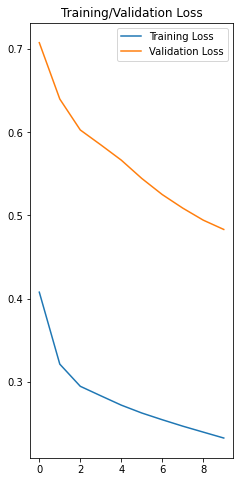

Epoch 1/10
31/31 [==============================] - 0s 5ms/step - loss: 0.3083 - mae: 0.2644 - rmse: 0.3083 - val_loss: 0.2303 - val_mae: 0.2017 - val_rmse: 0.2358
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2927 - mae: 0.2500 - rmse: 0.2927 - val_loss: 0.2330 - val_mae: 0.2008 - val_rmse: 0.2436
Epoch 3/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2741 - mae: 0.2321 - rmse: 0.2741 - val_loss: 0.2330 - val_mae: 0.1976 - val_rmse: 0.2445
Epoch 4/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2619 - mae: 0.2189 - rmse: 0.2619 - val_loss: 0.2323 - val_mae: 0.1942 - val_rmse: 0.2438
Epoch 5/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2494 - mae: 0.2067 - rmse: 0.2494 - val_loss: 0.2315 - val_mae: 0.1914 - val_rmse: 0.2413
Epoch 6/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2404 - mae: 0.1981 - rmse: 0.2404 - val_loss: 0.2293 - val_mae: 0.1889 - val_rmse: 0.2370
Epoch 7/10
31/31

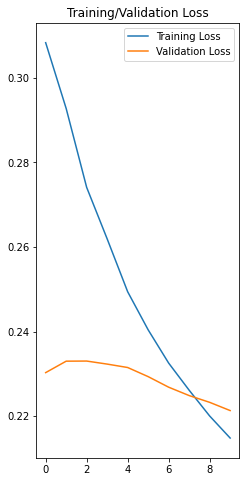

Epoch 1/10
47/47 [==============================] - 0s 5ms/step - loss: 0.2374 - mae: 0.2007 - rmse: 0.2391 - val_loss: 0.4474 - val_mae: 0.3946 - val_rmse: 0.4474
Epoch 2/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2330 - mae: 0.1954 - rmse: 0.2348 - val_loss: 0.3972 - val_mae: 0.3476 - val_rmse: 0.3972
Epoch 3/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2278 - mae: 0.1907 - rmse: 0.2295 - val_loss: 0.3729 - val_mae: 0.3226 - val_rmse: 0.3729
Epoch 4/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2152 - mae: 0.1803 - rmse: 0.2175 - val_loss: 0.3641 - val_mae: 0.3078 - val_rmse: 0.3641
Epoch 5/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2037 - mae: 0.1694 - rmse: 0.2062 - val_loss: 0.3407 - val_mae: 0.2837 - val_rmse: 0.3407
Epoch 6/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1962 - mae: 0.1633 - rmse: 0.1987 - val_loss: 0.3205 - val_mae: 0.2611 - val_rmse: 0.3205
Epoch 7/10
47/47

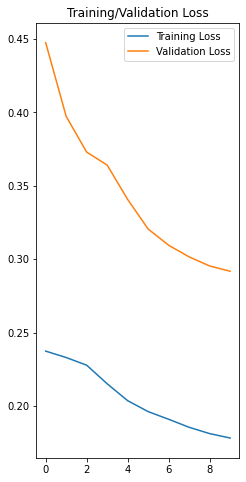

[[-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[ 98.44071  122.224945 143.46437  155.3932  ]]
Previsão:[[362.8132  332.1602  332.68945 339.858  ]]
Previsão:[[285.8719  276.55078 300.0987  293.23495]]
Previsão:[[207.33812 189.28516 205.73877 201.71918]]
Previsão:[[295.21378 292.3015  303.17786 294.74872]]
Previsão:[[303.04047 298.54352 292.7664  297.95538]]
Previsão:[[268.2328  236.33511 247.57986 236.20049]]
Previsão:[[243.86961 235.0376  247.16794 238.26262]]
Previsão:[[304.54782 303.2402  305.08517 303.24048]]
Previsão:[[280.30435 273.22308 271.0418  267.81174]]
Previsão:[[252.34853 244.64622 253.09702 245.98615]]
Previsão:[[281.62723 275.1285  277.40945 272.36765]]
Pr

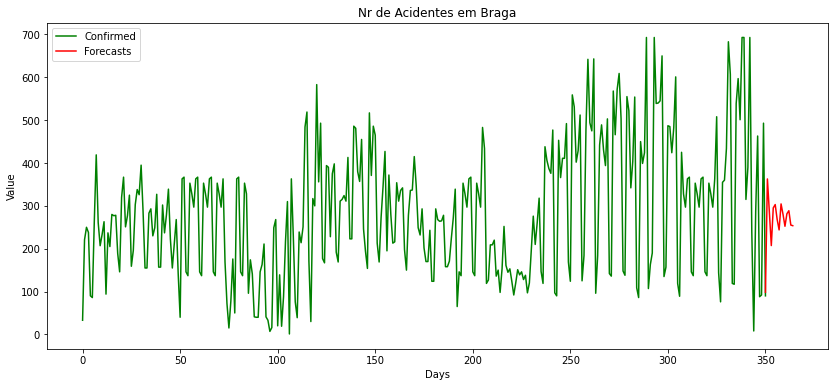

[array([[ 98.44071 , 122.224945, 143.46437 , 155.3932  ]], dtype=float32), array([[362.8132 , 332.1602 , 332.68945, 339.858  ]], dtype=float32), array([[285.8719 , 276.55078, 300.0987 , 293.23495]], dtype=float32), array([[207.33812, 189.28516, 205.73877, 201.71918]], dtype=float32), array([[295.21378, 292.3015 , 303.17786, 294.74872]], dtype=float32), array([[303.04047, 298.54352, 292.7664 , 297.95538]], dtype=float32), array([[268.2328 , 236.33511, 247.57986, 236.20049]], dtype=float32), array([[243.86961, 235.0376 , 247.16794, 238.26262]], dtype=float32), array([[304.54782, 303.2402 , 305.08517, 303.24048]], dtype=float32), array([[280.30435, 273.22308, 271.0418 , 267.81174]], dtype=float32), array([[252.34853, 244.64622, 253.09702, 245.98615]], dtype=float32), array([[281.62723, 275.1285 , 277.40945, 272.36765]], dtype=float32), array([[288.67838, 285.4654 , 286.2131 , 280.90457]], dtype=float32), array([[255.21066, 249.98921, 251.09608, 248.8599 ]], dtype=float32), array([[253.713

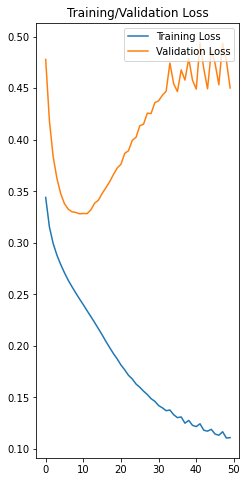

Epoch 1/50
31/31 [==============================] - 0s 4ms/step - loss: 0.2631 - mae: 0.2213 - rmse: 0.2631 - val_loss: 0.2164 - val_mae: 0.1778 - val_rmse: 0.2309
Epoch 2/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2357 - mae: 0.1934 - rmse: 0.2357 - val_loss: 0.2110 - val_mae: 0.1705 - val_rmse: 0.2268
Epoch 3/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2183 - mae: 0.1771 - rmse: 0.2183 - val_loss: 0.2151 - val_mae: 0.1769 - val_rmse: 0.2301
Epoch 4/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2096 - mae: 0.1702 - rmse: 0.2096 - val_loss: 0.2101 - val_mae: 0.1699 - val_rmse: 0.2229
Epoch 5/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2052 - mae: 0.1673 - rmse: 0.2052 - val_loss: 0.2071 - val_mae: 0.1677 - val_rmse: 0.2174
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 0.1976 - mae: 0.1608 - rmse: 0.1976 - val_loss: 0.2075 - val_mae: 0.1685 - val_rmse: 0.2154
Epoch 7/50
31/31

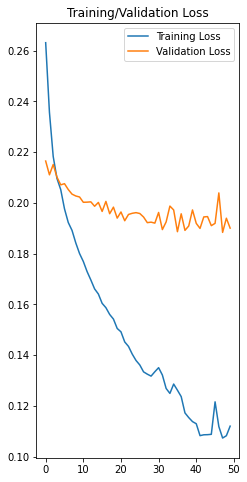

Epoch 1/50
47/47 [==============================] - 0s 5ms/step - loss: 0.1634 - mae: 0.1346 - rmse: 0.1661 - val_loss: 0.3526 - val_mae: 0.3115 - val_rmse: 0.3526
Epoch 2/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1555 - mae: 0.1292 - rmse: 0.1588 - val_loss: 0.3220 - val_mae: 0.2823 - val_rmse: 0.3220
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1486 - mae: 0.1256 - rmse: 0.1519 - val_loss: 0.3421 - val_mae: 0.3011 - val_rmse: 0.3421
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1467 - mae: 0.1217 - rmse: 0.1496 - val_loss: 0.3031 - val_mae: 0.2589 - val_rmse: 0.3031
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1389 - mae: 0.1162 - rmse: 0.1421 - val_loss: 0.3296 - val_mae: 0.2851 - val_rmse: 0.3296
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1379 - mae: 0.1152 - rmse: 0.1409 - val_loss: 0.3193 - val_mae: 0.2715 - val_rmse: 0.3193
Epoch 7/50
47/47

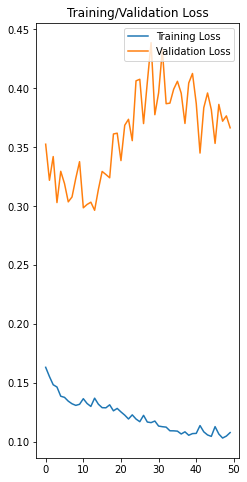

[[-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[81.53018 86.52881 91.37999 83.26639]]
Previsão:[[325.1275  318.56946 315.36243 316.36877]]
Previsão:[[523.82104 522.9973  519.10284 516.45984]]
Previsão:[[290.1214  281.62222 286.63666 282.09006]]
Previsão:[[ 5.3927226  1.126544   1.0374724 -1.7643347]]
Previsão:[[344.51193 348.4587  343.1829  341.03345]]
Previsão:[[382.39453 374.7881  372.9024  371.0382 ]]
Previsão:[[372.61063 365.83582 369.67584 363.09985]]
Previsão:[[285.95074 280.6201  274.6173  274.98276]]
Previsão:[[416.91516 422.58704 421.60632 417.14084]]
Previsão:[[262.06375 256.7083  252.32652 256.10464]]
Previsão:[[320.9271  325.59235 321.74536 320.60507]]
Previs

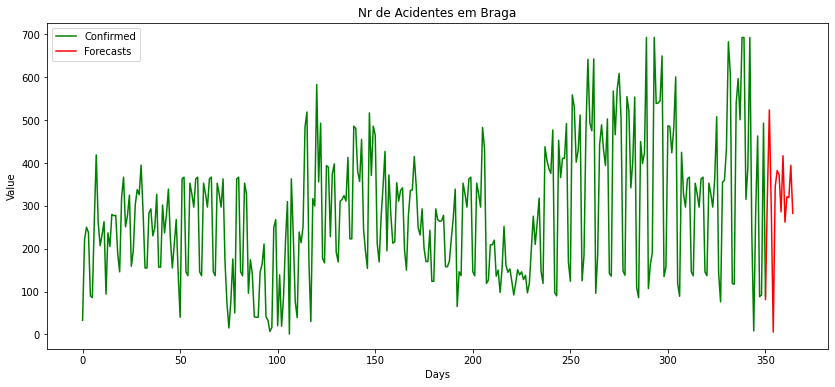

[array([[81.53018, 86.52881, 91.37999, 83.26639]], dtype=float32), array([[325.1275 , 318.56946, 315.36243, 316.36877]], dtype=float32), array([[523.82104, 522.9973 , 519.10284, 516.45984]], dtype=float32), array([[290.1214 , 281.62222, 286.63666, 282.09006]], dtype=float32), array([[ 5.3927226,  1.126544 ,  1.0374724, -1.7643347]], dtype=float32), array([[344.51193, 348.4587 , 343.1829 , 341.03345]], dtype=float32), array([[382.39453, 374.7881 , 372.9024 , 371.0382 ]], dtype=float32), array([[372.61063, 365.83582, 369.67584, 363.09985]], dtype=float32), array([[285.95074, 280.6201 , 274.6173 , 274.98276]], dtype=float32), array([[416.91516, 422.58704, 421.60632, 417.14084]], dtype=float32), array([[262.06375, 256.7083 , 252.32652, 256.10464]], dtype=float32), array([[320.9271 , 325.59235, 321.74536, 320.60507]], dtype=float32), array([[319.66455, 317.4475 , 318.67813, 315.58972]], dtype=float32), array([[394.58472, 396.3896 , 392.4785 , 392.96973]], dtype=float32), array([[282.42123, 

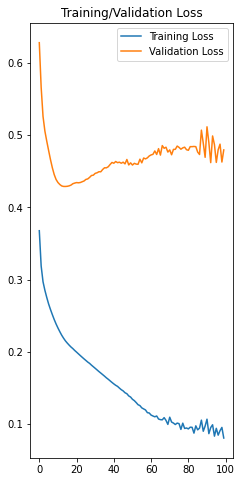

Epoch 1/100
31/31 [==============================] - 0s 5ms/step - loss: 0.2877 - mae: 0.2447 - rmse: 0.2877 - val_loss: 0.2914 - val_mae: 0.2317 - val_rmse: 0.3130
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 0.2522 - mae: 0.2141 - rmse: 0.2522 - val_loss: 0.2966 - val_mae: 0.2308 - val_rmse: 0.3221
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 0.2562 - mae: 0.2176 - rmse: 0.2562 - val_loss: 0.2922 - val_mae: 0.2256 - val_rmse: 0.3120
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 0.2473 - mae: 0.2105 - rmse: 0.2473 - val_loss: 0.2802 - val_mae: 0.2232 - val_rmse: 0.2987
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 0.2215 - mae: 0.1896 - rmse: 0.2215 - val_loss: 0.2825 - val_mae: 0.2229 - val_rmse: 0.3013
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 0.2181 - mae: 0.1855 - rmse: 0.2181 - val_loss: 0.2838 - val_mae: 0.2164 - val_rmse: 0.2980
Epoch 7/10

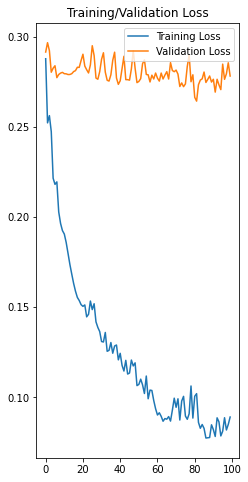

Epoch 1/100
47/47 [==============================] - 0s 6ms/step - loss: 0.1370 - mae: 0.1144 - rmse: 0.1405 - val_loss: 0.4846 - val_mae: 0.3960 - val_rmse: 0.4846
Epoch 2/100
47/47 [==============================] - 0s 3ms/step - loss: 0.1466 - mae: 0.1225 - rmse: 0.1499 - val_loss: 0.4495 - val_mae: 0.3756 - val_rmse: 0.4495
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1451 - mae: 0.1214 - rmse: 0.1477 - val_loss: 0.4055 - val_mae: 0.3460 - val_rmse: 0.4055
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1359 - mae: 0.1124 - rmse: 0.1387 - val_loss: 0.3987 - val_mae: 0.3416 - val_rmse: 0.3987
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1275 - mae: 0.1043 - rmse: 0.1306 - val_loss: 0.4051 - val_mae: 0.3581 - val_rmse: 0.4051
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1215 - mae: 0.0988 - rmse: 0.1246 - val_loss: 0.4016 - val_mae: 0.3470 - val_rmse: 0.4016
Epoch 7/10

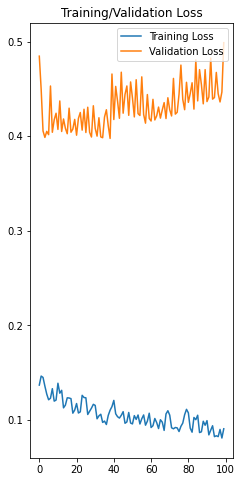

[[-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[201.15297 201.44281 200.35495 200.10745]]
Previsão:[[204.40236 204.6386  203.38405 205.54355]]
Previsão:[[316.0805  315.90317 315.64142 315.72562]]
Previsão:[[330.09003 330.54352 329.12695 329.4929 ]]
Previsão:[[180.60625 180.61609 180.09354 179.97997]]
Previsão:[[109.93506  109.92635  109.47879  109.236115]]
Previsão:[[519.39276 520.0388  518.2938  519.24396]]
Previsão:[[391.6847  391.8094  391.1391  391.80063]]
Previsão:[[200.07353 200.67607 198.94345 199.20284]]
Previsão:[[227.71747 227.75488 226.85295 227.96602]]
Previsão:[[301.9858  302.25098 301.00162 301.6585 ]]
Previsão:[[424.66425 425.11334 423.6776  425.8756 ]]
Pr

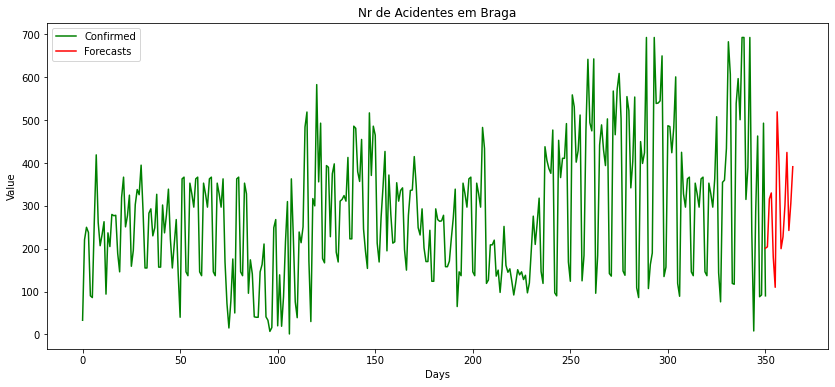

[array([[201.15297, 201.44281, 200.35495, 200.10745]], dtype=float32), array([[204.40236, 204.6386 , 203.38405, 205.54355]], dtype=float32), array([[316.0805 , 315.90317, 315.64142, 315.72562]], dtype=float32), array([[330.09003, 330.54352, 329.12695, 329.4929 ]], dtype=float32), array([[180.60625, 180.61609, 180.09354, 179.97997]], dtype=float32), array([[109.93506 , 109.92635 , 109.47879 , 109.236115]], dtype=float32), array([[519.39276, 520.0388 , 518.2938 , 519.24396]], dtype=float32), array([[391.6847 , 391.8094 , 391.1391 , 391.80063]], dtype=float32), array([[200.07353, 200.67607, 198.94345, 199.20284]], dtype=float32), array([[227.71747, 227.75488, 226.85295, 227.96602]], dtype=float32), array([[301.9858 , 302.25098, 301.00162, 301.6585 ]], dtype=float32), array([[424.66425, 425.11334, 423.6776 , 425.8756 ]], dtype=float32), array([[242.56699, 243.55022, 241.02307, 243.1332 ]], dtype=float32), array([[306.03403, 307.50708, 303.65063, 307.3724 ]], dtype=float32), array([[391.350

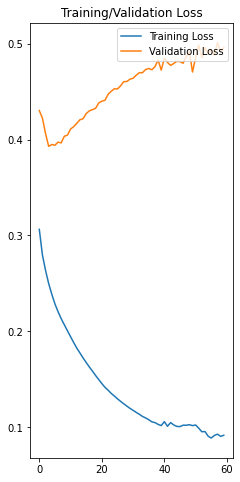

Epoch 1/60
31/31 [==============================] - 0s 4ms/step - loss: 0.2724 - mae: 0.2294 - rmse: 0.2715 - val_loss: 0.2134 - val_mae: 0.1824 - val_rmse: 0.2023
Epoch 2/60
31/31 [==============================] - 0s 3ms/step - loss: 0.2629 - mae: 0.2235 - rmse: 0.2617 - val_loss: 0.2138 - val_mae: 0.1763 - val_rmse: 0.2008
Epoch 3/60
31/31 [==============================] - 0s 3ms/step - loss: 0.2524 - mae: 0.2152 - rmse: 0.2513 - val_loss: 0.2149 - val_mae: 0.1794 - val_rmse: 0.2036
Epoch 4/60
31/31 [==============================] - 0s 3ms/step - loss: 0.2215 - mae: 0.1861 - rmse: 0.2208 - val_loss: 0.2200 - val_mae: 0.1876 - val_rmse: 0.2106
Epoch 5/60
31/31 [==============================] - 0s 3ms/step - loss: 0.2096 - mae: 0.1754 - rmse: 0.2089 - val_loss: 0.2181 - val_mae: 0.1844 - val_rmse: 0.2064
Epoch 6/60
31/31 [==============================] - 0s 3ms/step - loss: 0.2064 - mae: 0.1729 - rmse: 0.2058 - val_loss: 0.2149 - val_mae: 0.1809 - val_rmse: 0.1995
Epoch 7/60
31/31

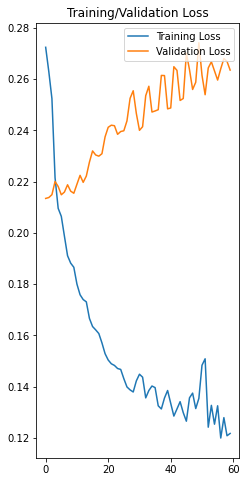

Epoch 1/60
47/47 [==============================] - 0s 6ms/step - loss: 0.1689 - mae: 0.1449 - rmse: 0.1712 - val_loss: 0.4158 - val_mae: 0.3612 - val_rmse: 0.4158
Epoch 2/60
47/47 [==============================] - 0s 3ms/step - loss: 0.1822 - mae: 0.1562 - rmse: 0.1832 - val_loss: 0.3890 - val_mae: 0.3233 - val_rmse: 0.3890
Epoch 3/60
47/47 [==============================] - 0s 3ms/step - loss: 0.1661 - mae: 0.1405 - rmse: 0.1672 - val_loss: 0.3830 - val_mae: 0.3129 - val_rmse: 0.3830
Epoch 4/60
47/47 [==============================] - 0s 2ms/step - loss: 0.1521 - mae: 0.1256 - rmse: 0.1537 - val_loss: 0.3743 - val_mae: 0.3097 - val_rmse: 0.3743
Epoch 5/60
47/47 [==============================] - 0s 3ms/step - loss: 0.1467 - mae: 0.1213 - rmse: 0.1479 - val_loss: 0.3851 - val_mae: 0.3251 - val_rmse: 0.3851
Epoch 6/60
47/47 [==============================] - 0s 3ms/step - loss: 0.1494 - mae: 0.1263 - rmse: 0.1499 - val_loss: 0.3900 - val_mae: 0.3204 - val_rmse: 0.3900
Epoch 7/60
47/47

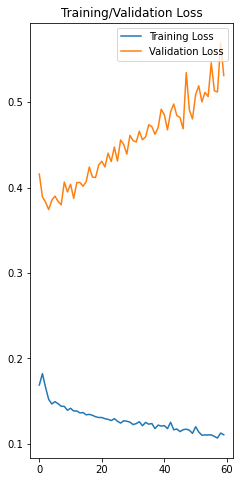

[[-0.31213873 -0.70687289  0.07351247 -0.20634921]
 [-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[-14.687744 -14.602282 -13.708966 -13.77393 ]]
Previsão:[[280.0449  272.95908 276.69888 269.77286]]
Previsão:[[572.5781  574.6944  571.07007 568.3837 ]]
Previsão:[[365.1584  367.1495  364.0679  363.24332]]
Previsão:[[247.65564 232.37863 236.62195 235.41278]]
Previsão:[[421.6962  406.67648 410.31528 406.68762]]
Previsão:[[496.56628 502.54688 498.58823 495.92017]]
Previsão:[[221.0771  227.6155  219.45566 220.84145]]
Previsão:[[215.19672 214.7705  212.58665 208.54535]]
Previsão:[[410.379   410.52118 407.6126  404.26678]]
Previsão:[[589.0198  599.39484 592.1562  588.83856]]
Prev

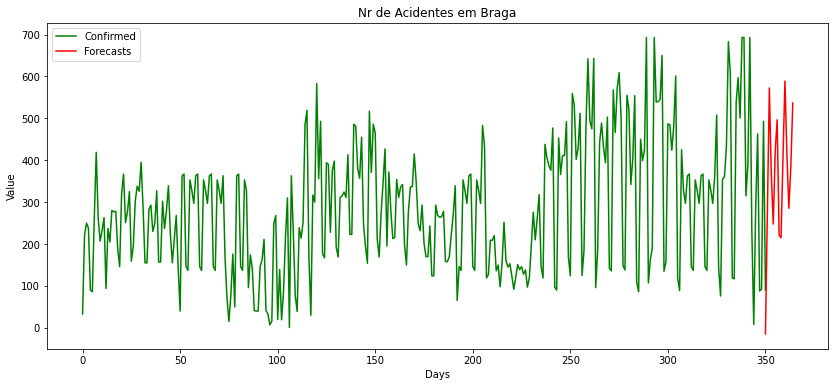

[array([[-14.687744, -14.602282, -13.708966, -13.77393 ]], dtype=float32), array([[280.0449 , 272.95908, 276.69888, 269.77286]], dtype=float32), array([[572.5781 , 574.6944 , 571.07007, 568.3837 ]], dtype=float32), array([[365.1584 , 367.1495 , 364.0679 , 363.24332]], dtype=float32), array([[247.65564, 232.37863, 236.62195, 235.41278]], dtype=float32), array([[421.6962 , 406.67648, 410.31528, 406.68762]], dtype=float32), array([[496.56628, 502.54688, 498.58823, 495.92017]], dtype=float32), array([[221.0771 , 227.6155 , 219.45566, 220.84145]], dtype=float32), array([[215.19672, 214.7705 , 212.58665, 208.54535]], dtype=float32), array([[410.379  , 410.52118, 407.6126 , 404.26678]], dtype=float32), array([[589.0198 , 599.39484, 592.1562 , 588.83856]], dtype=float32), array([[412.22086, 423.2342 , 414.46332, 413.93478]], dtype=float32), array([[285.33224, 286.27618, 282.48062, 281.21243]], dtype=float32), array([[383.6145 , 381.45175, 378.34357, 377.23544]], dtype=float32), array([[536.552

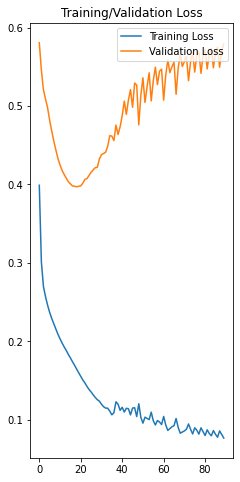

Epoch 1/90
31/31 [==============================] - 0s 5ms/step - loss: 0.2555 - mae: 0.2114 - rmse: 0.2546 - val_loss: 0.2792 - val_mae: 0.2324 - val_rmse: 0.2733
Epoch 2/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2441 - mae: 0.2016 - rmse: 0.2431 - val_loss: 0.2706 - val_mae: 0.2278 - val_rmse: 0.2605
Epoch 3/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2360 - mae: 0.1966 - rmse: 0.2349 - val_loss: 0.2612 - val_mae: 0.2174 - val_rmse: 0.2514
Epoch 4/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2144 - mae: 0.1777 - rmse: 0.2134 - val_loss: 0.2604 - val_mae: 0.2169 - val_rmse: 0.2491
Epoch 5/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2098 - mae: 0.1750 - rmse: 0.2088 - val_loss: 0.2498 - val_mae: 0.2096 - val_rmse: 0.2377
Epoch 6/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2034 - mae: 0.1691 - rmse: 0.2024 - val_loss: 0.2519 - val_mae: 0.2098 - val_rmse: 0.2387
Epoch 7/90
31/31

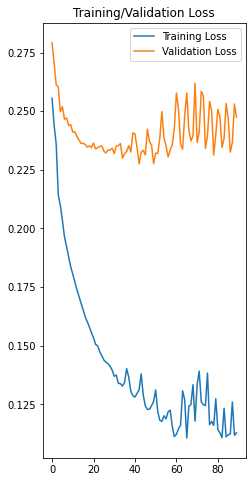

Epoch 1/90
47/47 [==============================] - 0s 6ms/step - loss: 0.1823 - mae: 0.1531 - rmse: 0.1799 - val_loss: 0.3641 - val_mae: 0.3344 - val_rmse: 0.3641
Epoch 2/90
47/47 [==============================] - 0s 3ms/step - loss: 0.1811 - mae: 0.1530 - rmse: 0.1792 - val_loss: 0.3648 - val_mae: 0.3296 - val_rmse: 0.3648
Epoch 3/90
47/47 [==============================] - 0s 3ms/step - loss: 0.1701 - mae: 0.1452 - rmse: 0.1675 - val_loss: 0.3525 - val_mae: 0.3187 - val_rmse: 0.3525
Epoch 4/90
47/47 [==============================] - 0s 3ms/step - loss: 0.1778 - mae: 0.1497 - rmse: 0.1751 - val_loss: 0.3400 - val_mae: 0.3032 - val_rmse: 0.3400
Epoch 5/90
47/47 [==============================] - 0s 3ms/step - loss: 0.1590 - mae: 0.1308 - rmse: 0.1570 - val_loss: 0.3442 - val_mae: 0.3069 - val_rmse: 0.3442
Epoch 6/90
47/47 [==============================] - 0s 3ms/step - loss: 0.1498 - mae: 0.1245 - rmse: 0.1484 - val_loss: 0.3422 - val_mae: 0.3022 - val_rmse: 0.3422
Epoch 7/90
47/47

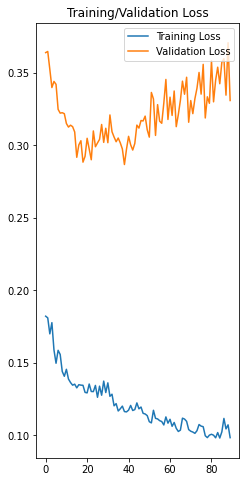

[[-0.31213873 -0.70687289  0.07351247 -0.20634921]
 [-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[-88.76952  -88.34728  -87.65228  -85.161865]]
Previsão:[[235.15784 235.61989 235.85164 234.87053]]
Previsão:[[382.7225  381.0439  384.3399  380.74454]]
Previsão:[[360.2928  359.02963 361.74808 361.16742]]
Previsão:[[-52.007294 -51.849197 -51.874935 -54.70089 ]]
Previsão:[[401.35083 403.76288 401.69034 403.06628]]
Previsão:[[584.4731  586.7801  586.46497 589.44965]]
Previsão:[[369.3112  370.3409  368.98996 362.6472 ]]
Previsão:[[-80.58673 -81.31262 -79.27971 -80.52086]]
Previsão:[[383.611   385.71362 383.58444 383.313  ]]
Previsão:[[462.06564 464.5806  463.5023  464.9279 ]]


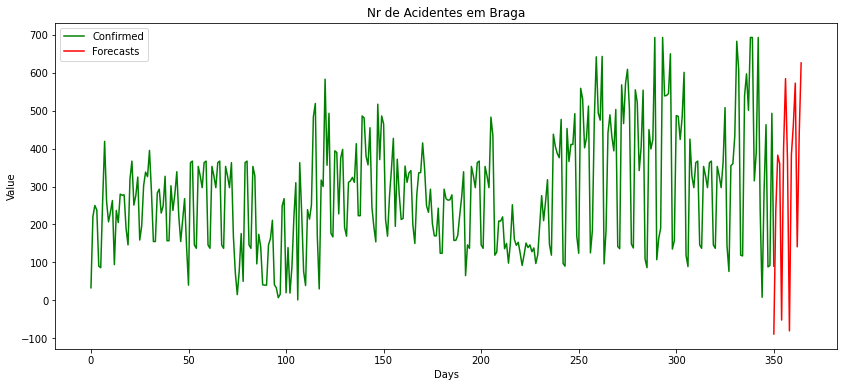

[array([[-88.76952 , -88.34728 , -87.65228 , -85.161865]], dtype=float32), array([[235.15784, 235.61989, 235.85164, 234.87053]], dtype=float32), array([[382.7225 , 381.0439 , 384.3399 , 380.74454]], dtype=float32), array([[360.2928 , 359.02963, 361.74808, 361.16742]], dtype=float32), array([[-52.007294, -51.849197, -51.874935, -54.70089 ]], dtype=float32), array([[401.35083, 403.76288, 401.69034, 403.06628]], dtype=float32), array([[584.4731 , 586.7801 , 586.46497, 589.44965]], dtype=float32), array([[369.3112 , 370.3409 , 368.98996, 362.6472 ]], dtype=float32), array([[-80.58673, -81.31262, -79.27971, -80.52086]], dtype=float32), array([[383.611  , 385.71362, 383.58444, 383.313  ]], dtype=float32), array([[462.06564, 464.5806 , 463.5023 , 464.9279 ]], dtype=float32), array([[572.5401 , 574.8398 , 572.47644, 571.0576 ]], dtype=float32), array([[141.0938 , 142.05287, 142.37888, 140.71103]], dtype=float32), array([[435.86963, 439.6195 , 435.50043, 436.60187]], dtype=float32), array([[625

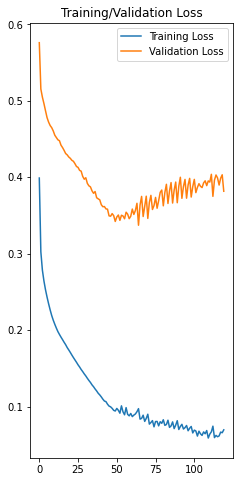

Epoch 1/120
31/31 [==============================] - 0s 5ms/step - loss: 0.2855 - mae: 0.2372 - rmse: 0.2850 - val_loss: 0.2442 - val_mae: 0.2047 - val_rmse: 0.2349
Epoch 2/120
31/31 [==============================] - 0s 4ms/step - loss: 0.2510 - mae: 0.2086 - rmse: 0.2504 - val_loss: 0.2459 - val_mae: 0.1939 - val_rmse: 0.2455
Epoch 3/120
31/31 [==============================] - 0s 4ms/step - loss: 0.2428 - mae: 0.2051 - rmse: 0.2428 - val_loss: 0.2577 - val_mae: 0.2160 - val_rmse: 0.2547
Epoch 4/120
31/31 [==============================] - 0s 4ms/step - loss: 0.2118 - mae: 0.1805 - rmse: 0.2116 - val_loss: 0.2464 - val_mae: 0.1991 - val_rmse: 0.2476
Epoch 5/120
31/31 [==============================] - 0s 3ms/step - loss: 0.2099 - mae: 0.1754 - rmse: 0.2096 - val_loss: 0.2360 - val_mae: 0.1888 - val_rmse: 0.2354
Epoch 6/120
31/31 [==============================] - 0s 3ms/step - loss: 0.2030 - mae: 0.1713 - rmse: 0.2029 - val_loss: 0.2354 - val_mae: 0.1911 - val_rmse: 0.2352
Epoch 7/12

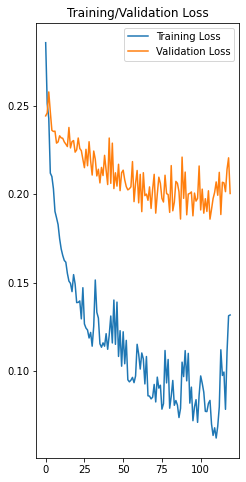

Epoch 1/120
47/47 [==============================] - 0s 6ms/step - loss: 0.1259 - mae: 0.1072 - rmse: 0.1292 - val_loss: 0.5695 - val_mae: 0.4492 - val_rmse: 0.5695
Epoch 2/120
47/47 [==============================] - 0s 3ms/step - loss: 0.1660 - mae: 0.1472 - rmse: 0.1655 - val_loss: 0.5248 - val_mae: 0.4221 - val_rmse: 0.5248
Epoch 3/120
47/47 [==============================] - 0s 3ms/step - loss: 0.1210 - mae: 0.1024 - rmse: 0.1217 - val_loss: 0.5437 - val_mae: 0.4401 - val_rmse: 0.5437
Epoch 4/120
47/47 [==============================] - 0s 3ms/step - loss: 0.1096 - mae: 0.0912 - rmse: 0.1106 - val_loss: 0.5409 - val_mae: 0.4381 - val_rmse: 0.5409
Epoch 5/120
47/47 [==============================] - 0s 3ms/step - loss: 0.1138 - mae: 0.0939 - rmse: 0.1146 - val_loss: 0.5280 - val_mae: 0.4254 - val_rmse: 0.5280
Epoch 6/120
47/47 [==============================] - 0s 3ms/step - loss: 0.1083 - mae: 0.0894 - rmse: 0.1081 - val_loss: 0.5568 - val_mae: 0.4543 - val_rmse: 0.5568
Epoch 7/12

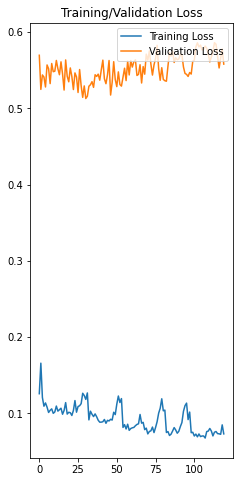

[[-0.31213873 -0.70687289  0.07351247 -0.20634921]
 [-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[105.850815 105.59558  105.343056 107.904686]]
Previsão:[[192.93532 192.38548 193.05106 193.36765]]
Previsão:[[485.11868 486.54172 485.36813 485.61844]]
Previsão:[[256.74844 256.3669  256.3871  256.43597]]
Previsão:[[233.03323 231.53586 232.78757 232.88834]]
Previsão:[[231.80728 232.24248 231.72086 233.82039]]
Previsão:[[420.7914  420.88925 420.34604 421.1002 ]]
Previsão:[[157.92755 156.93384 157.5197  158.42989]]
Previsão:[[392.591   393.3995  391.72528 395.29648]]
Previsão:[[327.0554 328.1591 326.8092 328.4866]]
Previsão:[[395.42902 395.40222 394.83942 395.5501 ]]
Previsão

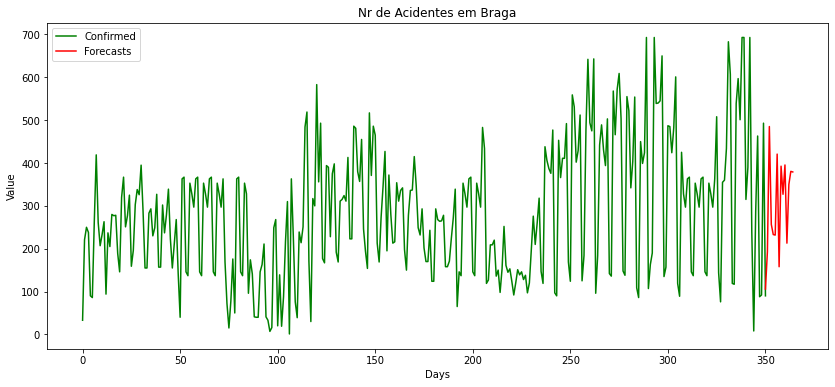

[array([[105.850815, 105.59558 , 105.343056, 107.904686]], dtype=float32), array([[192.93532, 192.38548, 193.05106, 193.36765]], dtype=float32), array([[485.11868, 486.54172, 485.36813, 485.61844]], dtype=float32), array([[256.74844, 256.3669 , 256.3871 , 256.43597]], dtype=float32), array([[233.03323, 231.53586, 232.78757, 232.88834]], dtype=float32), array([[231.80728, 232.24248, 231.72086, 233.82039]], dtype=float32), array([[420.7914 , 420.88925, 420.34604, 421.1002 ]], dtype=float32), array([[157.92755, 156.93384, 157.5197 , 158.42989]], dtype=float32), array([[392.591  , 393.3995 , 391.72528, 395.29648]], dtype=float32), array([[327.0554, 328.1591, 326.8092, 328.4866]], dtype=float32), array([[395.42902, 395.40222, 394.83942, 395.5501 ]], dtype=float32), array([[212.97057, 211.86247, 212.78749, 212.41113]], dtype=float32), array([[349.8517 , 350.22125, 349.69873, 351.7111 ]], dtype=float32), array([[380.487  , 380.82434, 380.23596, 380.79626]], dtype=float32), array([[379.1106 , 

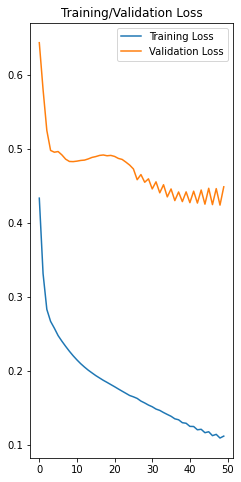

Epoch 1/50
20/20 [==============================] - 0s 6ms/step - loss: 0.2866 - mae: 0.2368 - rmse: 0.2766 - val_loss: 0.2155 - val_mae: 0.1816 - val_rmse: 0.2155
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2504 - mae: 0.2022 - rmse: 0.2403 - val_loss: 0.2213 - val_mae: 0.1845 - val_rmse: 0.2213
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2319 - mae: 0.1874 - rmse: 0.2221 - val_loss: 0.2324 - val_mae: 0.1929 - val_rmse: 0.2324
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2177 - mae: 0.1731 - rmse: 0.2118 - val_loss: 0.2399 - val_mae: 0.1985 - val_rmse: 0.2399
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2083 - mae: 0.1658 - rmse: 0.1999 - val_loss: 0.2267 - val_mae: 0.1873 - val_rmse: 0.2267
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2027 - mae: 0.1603 - rmse: 0.1953 - val_loss: 0.2225 - val_mae: 0.1840 - val_rmse: 0.2225
Epoch 7/50
20/20

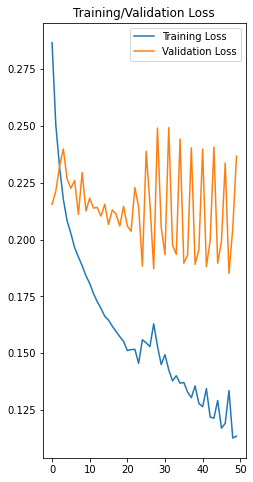

Epoch 1/50
29/29 [==============================] - 0s 5ms/step - loss: 0.1832 - mae: 0.1521 - rmse: 0.1843 - val_loss: 0.3260 - val_mae: 0.2870 - val_rmse: 0.2991
Epoch 2/50
29/29 [==============================] - 0s 4ms/step - loss: 0.1675 - mae: 0.1374 - rmse: 0.1686 - val_loss: 0.3171 - val_mae: 0.2812 - val_rmse: 0.2807
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 0.1702 - mae: 0.1412 - rmse: 0.1709 - val_loss: 0.2592 - val_mae: 0.2271 - val_rmse: 0.2179
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 0.1653 - mae: 0.1348 - rmse: 0.1662 - val_loss: 0.2805 - val_mae: 0.2496 - val_rmse: 0.2368
Epoch 5/50
29/29 [==============================] - 0s 4ms/step - loss: 0.1475 - mae: 0.1175 - rmse: 0.1489 - val_loss: 0.3183 - val_mae: 0.2817 - val_rmse: 0.2713
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 0.1644 - mae: 0.1365 - rmse: 0.1648 - val_loss: 0.2536 - val_mae: 0.2183 - val_rmse: 0.2245
Epoch 7/50
29/29

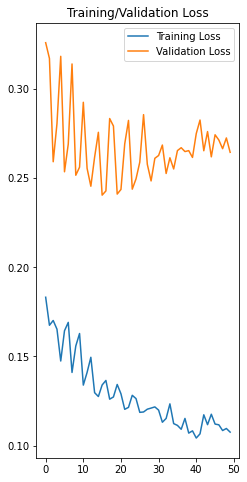

[[ 0.12427746 -0.46289151  0.23850523  0.11904762]
 [ 1.         -0.22331485  0.60676194  1.        ]
 [-0.31213873 -0.70687289  0.07351247 -0.20634921]
 [-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[115.226456 126.4852   104.44759  118.28148 ]]
Previsão:[[190.05214 194.22623 182.72537 205.8247 ]]
Previsão:[[309.54834 314.8278  303.12958 315.51123]]
Previsão:[[300.16733 306.08548 296.5219  300.26086]]
Previsão:[[181.16565 189.26472 176.6112  189.91   ]]
Previsão:[[359.6516  362.4298  358.5799  359.02933]]
Previsão:[[379.6025  382.44604 379.32642 380.29037]]
Previsão:[[247.25676 251.97125 252.20988 245.77597]]
Previsão:[[266.58002 262.42606 264.86386 265.43408]]
Previsão

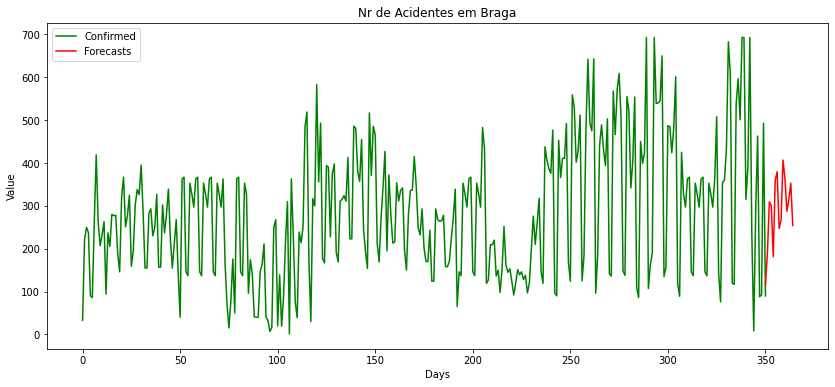

[array([[115.226456, 126.4852  , 104.44759 , 118.28148 ]], dtype=float32), array([[190.05214, 194.22623, 182.72537, 205.8247 ]], dtype=float32), array([[309.54834, 314.8278 , 303.12958, 315.51123]], dtype=float32), array([[300.16733, 306.08548, 296.5219 , 300.26086]], dtype=float32), array([[181.16565, 189.26472, 176.6112 , 189.91   ]], dtype=float32), array([[359.6516 , 362.4298 , 358.5799 , 359.02933]], dtype=float32), array([[379.6025 , 382.44604, 379.32642, 380.29037]], dtype=float32), array([[247.25676, 251.97125, 252.20988, 245.77597]], dtype=float32), array([[266.58002, 262.42606, 264.86386, 265.43408]], dtype=float32), array([[406.92508, 400.80576, 409.06784, 400.8951 ]], dtype=float32), array([[363.11908, 365.72675, 364.0172 , 364.21136]], dtype=float32), array([[287.16   , 289.56616, 289.8857 , 285.3486 ]], dtype=float32), array([[315.2237 , 310.05225, 317.83475, 310.77774]], dtype=float32), array([[352.92807, 349.1126 , 355.6456 , 346.1207 ]], dtype=float32), array([[254.262

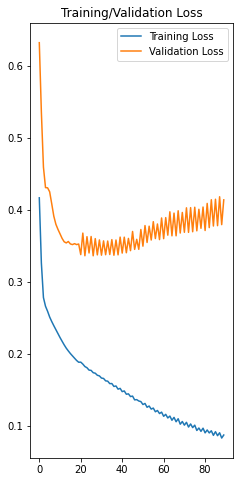

Epoch 1/90
20/20 [==============================] - 0s 6ms/step - loss: 0.2519 - mae: 0.2062 - rmse: 0.2417 - val_loss: 0.1910 - val_mae: 0.1454 - val_rmse: 0.1910
Epoch 2/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2324 - mae: 0.1865 - rmse: 0.2244 - val_loss: 0.1968 - val_mae: 0.1540 - val_rmse: 0.1968
Epoch 3/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2151 - mae: 0.1728 - rmse: 0.2070 - val_loss: 0.2031 - val_mae: 0.1507 - val_rmse: 0.2031
Epoch 4/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2031 - mae: 0.1634 - rmse: 0.1952 - val_loss: 0.1973 - val_mae: 0.1451 - val_rmse: 0.1973
Epoch 5/90
20/20 [==============================] - 0s 4ms/step - loss: 0.1949 - mae: 0.1574 - rmse: 0.1895 - val_loss: 0.2065 - val_mae: 0.1512 - val_rmse: 0.2065
Epoch 6/90
20/20 [==============================] - 0s 4ms/step - loss: 0.1855 - mae: 0.1498 - rmse: 0.1781 - val_loss: 0.2025 - val_mae: 0.1492 - val_rmse: 0.2025
Epoch 7/90
20/20

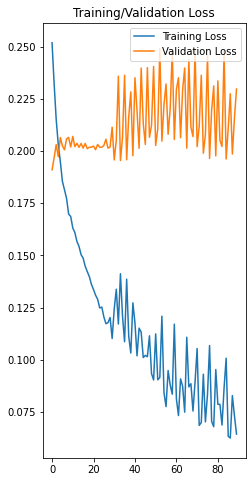

Epoch 1/90
29/29 [==============================] - 0s 5ms/step - loss: 0.1538 - mae: 0.1289 - rmse: 0.1551 - val_loss: 0.6001 - val_mae: 0.5074 - val_rmse: 0.5560
Epoch 2/90
29/29 [==============================] - 0s 4ms/step - loss: 0.1460 - mae: 0.1216 - rmse: 0.1474 - val_loss: 0.6157 - val_mae: 0.5186 - val_rmse: 0.5801
Epoch 3/90
29/29 [==============================] - 0s 4ms/step - loss: 0.1485 - mae: 0.1266 - rmse: 0.1495 - val_loss: 0.6020 - val_mae: 0.5179 - val_rmse: 0.5814
Epoch 4/90
29/29 [==============================] - 0s 4ms/step - loss: 0.1265 - mae: 0.1038 - rmse: 0.1277 - val_loss: 0.6010 - val_mae: 0.5216 - val_rmse: 0.5855
Epoch 5/90
29/29 [==============================] - 0s 4ms/step - loss: 0.1228 - mae: 0.1008 - rmse: 0.1238 - val_loss: 0.6005 - val_mae: 0.5125 - val_rmse: 0.5689
Epoch 6/90
29/29 [==============================] - 0s 4ms/step - loss: 0.1258 - mae: 0.1030 - rmse: 0.1270 - val_loss: 0.5983 - val_mae: 0.5206 - val_rmse: 0.5887
Epoch 7/90
29/29

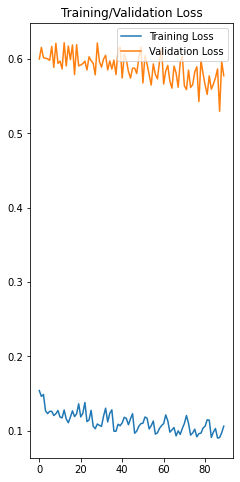

[[ 0.12427746 -0.46289151  0.23850523  0.11904762]
 [ 1.         -0.22331485  0.60676194  1.        ]
 [-0.31213873 -0.70687289  0.07351247 -0.20634921]
 [-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[55.851295 54.508766 65.75155  59.89503 ]]
Previsão:[[380.33676 382.53632 390.23907 381.4526 ]]
Previsão:[[406.73724 400.63297 409.804   401.78796]]
Previsão:[[115.864845 122.98728  128.42406  126.23667 ]]
Previsão:[[322.2186  323.4515  328.53708 321.07065]]
Previsão:[[427.87357 425.6585  433.3054  427.32297]]
Previsão:[[363.21375 365.71936 369.5323  367.42975]]
Previsão:[[213.15062 209.4116  217.88641 213.63708]]
Previsão:[[402.78665 404.6633  407.99423 407.94565]]
Previsão

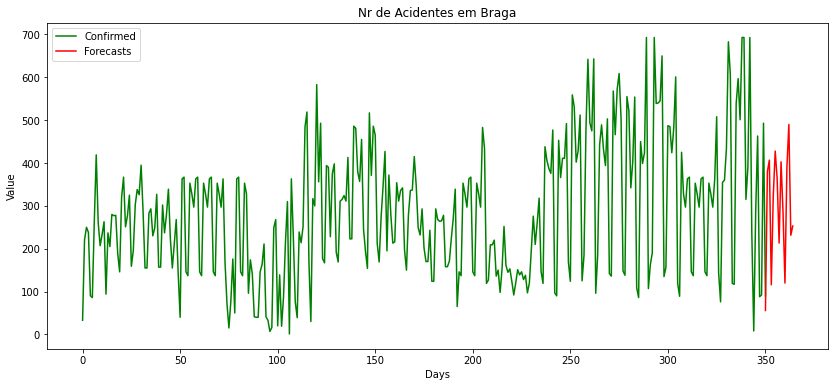

[array([[55.851295, 54.508766, 65.75155 , 59.89503 ]], dtype=float32), array([[380.33676, 382.53632, 390.23907, 381.4526 ]], dtype=float32), array([[406.73724, 400.63297, 409.804  , 401.78796]], dtype=float32), array([[115.864845, 122.98728 , 128.42406 , 126.23667 ]], dtype=float32), array([[322.2186 , 323.4515 , 328.53708, 321.07065]], dtype=float32), array([[427.87357, 425.6585 , 433.3054 , 427.32297]], dtype=float32), array([[363.21375, 365.71936, 369.5323 , 367.42975]], dtype=float32), array([[213.15062, 209.4116 , 217.88641, 213.63708]], dtype=float32), array([[402.78665, 404.6633 , 407.99423, 407.94565]], dtype=float32), array([[286.4868 , 292.73145, 293.0385 , 293.4144 ]], dtype=float32), array([[119.80941 , 126.52259 , 127.47373 , 124.583824]], dtype=float32), array([[391.1037 , 390.53726, 396.49432, 393.28607]], dtype=float32), array([[489.95816, 491.7299 , 495.63647, 496.65033]], dtype=float32), array([[231.43369, 243.36748, 242.3577 , 244.02267]], dtype=float32), array([[252

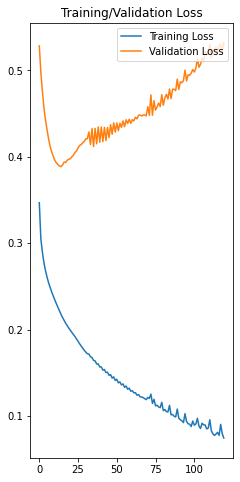

Epoch 1/120
20/20 [==============================] - 0s 6ms/step - loss: 0.2670 - mae: 0.2203 - rmse: 0.2571 - val_loss: 0.2312 - val_mae: 0.1846 - val_rmse: 0.2312
Epoch 2/120
20/20 [==============================] - 0s 5ms/step - loss: 0.2464 - mae: 0.2043 - rmse: 0.2375 - val_loss: 0.2300 - val_mae: 0.1805 - val_rmse: 0.2300
Epoch 3/120
20/20 [==============================] - 0s 5ms/step - loss: 0.2359 - mae: 0.1951 - rmse: 0.2276 - val_loss: 0.2249 - val_mae: 0.1791 - val_rmse: 0.2249
Epoch 4/120
20/20 [==============================] - 0s 6ms/step - loss: 0.2137 - mae: 0.1752 - rmse: 0.2052 - val_loss: 0.2255 - val_mae: 0.1775 - val_rmse: 0.2255
Epoch 5/120
20/20 [==============================] - 0s 5ms/step - loss: 0.2084 - mae: 0.1717 - rmse: 0.2030 - val_loss: 0.2197 - val_mae: 0.1752 - val_rmse: 0.2197
Epoch 6/120
20/20 [==============================] - 0s 6ms/step - loss: 0.2042 - mae: 0.1688 - rmse: 0.1964 - val_loss: 0.2165 - val_mae: 0.1737 - val_rmse: 0.2165
Epoch 7/12

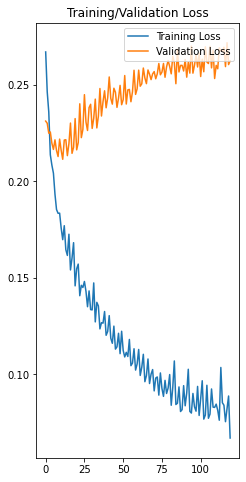

Epoch 1/120
29/29 [==============================] - 0s 6ms/step - loss: 0.1489 - mae: 0.1218 - rmse: 0.1504 - val_loss: 0.4733 - val_mae: 0.4324 - val_rmse: 0.6046
Epoch 2/120
29/29 [==============================] - 0s 4ms/step - loss: 0.1467 - mae: 0.1244 - rmse: 0.1478 - val_loss: 0.5125 - val_mae: 0.4771 - val_rmse: 0.6585
Epoch 3/120
29/29 [==============================] - 0s 4ms/step - loss: 0.1291 - mae: 0.1068 - rmse: 0.1301 - val_loss: 0.5066 - val_mae: 0.4729 - val_rmse: 0.6528
Epoch 4/120
29/29 [==============================] - 0s 4ms/step - loss: 0.1202 - mae: 0.0979 - rmse: 0.1213 - val_loss: 0.4856 - val_mae: 0.4483 - val_rmse: 0.6205
Epoch 5/120
29/29 [==============================] - 0s 3ms/step - loss: 0.1268 - mae: 0.1048 - rmse: 0.1279 - val_loss: 0.5253 - val_mae: 0.4889 - val_rmse: 0.6692
Epoch 6/120
29/29 [==============================] - 0s 3ms/step - loss: 0.1251 - mae: 0.1032 - rmse: 0.1261 - val_loss: 0.5060 - val_mae: 0.4699 - val_rmse: 0.6510
Epoch 7/12

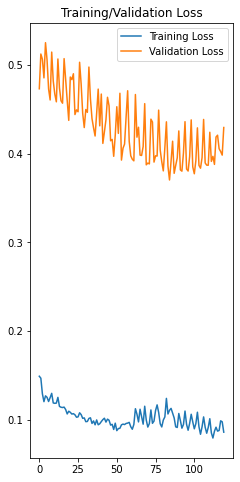

[[ 0.12427746 -0.46289151  0.23850523  0.11904762]
 [ 1.         -0.22331485  0.60676194  1.        ]
 [-0.31213873 -0.70687289  0.07351247 -0.20634921]
 [-0.97976879 -0.90309723 -0.62119612 -0.96031746]
 [-0.1734104  -0.22814325  0.01867398 -0.11111111]
 [ 0.33526012 -0.41802439  0.23234742  0.22222222]
 [-0.74855491 -1.          0.08698858 -0.4047619 ]
 [-0.73699422 -0.36919108  0.26229836 -0.46031746]
 [ 0.42196532 -0.40912734  0.25394301  0.20634921]
 [-0.74277457 -0.81465154  0.19463521 -0.53968254]]
Previsão:[[145.53165 148.59521 143.55309 150.15114]]
Previsão:[[346.1705  350.98108 343.68683 353.1335 ]]
Previsão:[[375.55624 380.83496 373.06717 376.59854]]
Previsão:[[206.67967 211.14941 204.28482 209.77724]]
Previsão:[[207.60042 213.58682 206.86316 211.24152]]
Previsão:[[436.33475 437.24875 434.10736 439.25708]]
Previsão:[[355.97977 358.48367 354.88666 356.59995]]
Previsão:[[291.94565 294.95496 290.09738 293.4027 ]]
Previsão:[[387.71704 390.7266  386.75922 389.38025]]
Previsão:[[3

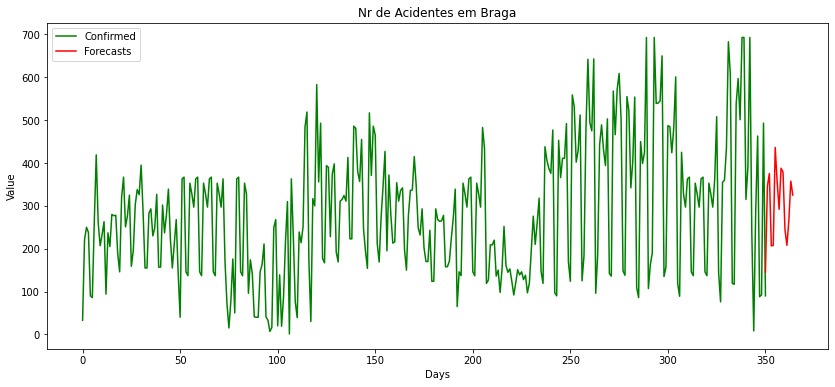

[array([[145.53165, 148.59521, 143.55309, 150.15114]], dtype=float32), array([[346.1705 , 350.98108, 343.68683, 353.1335 ]], dtype=float32), array([[375.55624, 380.83496, 373.06717, 376.59854]], dtype=float32), array([[206.67967, 211.14941, 204.28482, 209.77724]], dtype=float32), array([[207.60042, 213.58682, 206.86316, 211.24152]], dtype=float32), array([[436.33475, 437.24875, 434.10736, 439.25708]], dtype=float32), array([[355.97977, 358.48367, 354.88666, 356.59995]], dtype=float32), array([[291.94565, 294.95496, 290.09738, 293.4027 ]], dtype=float32), array([[387.71704, 390.7266 , 386.75922, 389.38025]], dtype=float32), array([[378.73752, 379.88477, 377.14526, 380.04883]], dtype=float32), array([[244.7468 , 247.10652, 242.64413, 245.99718]], dtype=float32), array([[207.92659, 210.92041, 205.55838, 210.7245 ]], dtype=float32), array([[266.46292, 269.1252 , 264.48813, 268.3556 ]], dtype=float32), array([[357.66956, 359.35434, 356.44403, 358.6984 ]], dtype=float32), array([[325.1872 , 

In [30]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('dataset_test_v3.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                  2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  
                  4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  
                  7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)
   plot_forecast(df_data, forecasts)
   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [31]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.24609895646572114, 0.20822163472572963, 0.24717110395431516, 0.379465893904368, 0.3361279631654422, 0.3769154076774915] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.15075607826312384, 0.12443967367211976, 0.15190040588378906, 0.32242037445306776, 0.25967443426450093, 0.32221723596254986] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.12734345063567162, 0.10462480283031861, 0.1281696103264888, 0.39276442557573316, 0.3298836201429367, 0.3935629785060883] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.14157059904601837, 0.11812602293988068, 0.14084657782481777, 0.38353457012110287, 0.3297312398751577, 0.3728044008215268] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.13066723313596515, 0.10860178470611574, 0.12962124629153146, 0.35311277977846284, 0.3004812834991349, 0.341363

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.246099,0.208222,0.247171,0.379466,0.336128,0.376915
2,0.150756,0.124440,0.151900,0.322420,0.259674,0.322217
3,0.127343,0.104625,0.128170,0.392764,0.329884,0.393563
4,0.141571,0.118126,0.140847,0.383535,0.329731,0.372804
5,0.130667,0.108602,0.129621,0.353113,0.300481,0.341363
6,0.107875,0.089597,0.107235,0.384865,0.321072,0.383152
7,0.155448,0.125672,0.152797,0.317674,0.271351,0.305135
8,0.126543,0.104217,0.124366,0.392529,0.321357,0.375441
9,0.121854,0.098518,0.120259,0.376837,0.315622,0.393932
